In [41]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dense,Flatten

In [2]:
df=pd.read_csv('/kaggle/input/nids-v1/NF-UQ-NIDS.csv')
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Dataset
0,149.171.126.0,62073,59.166.0.5,56082,6,0.0,9672,416,11,8,25,15,0,Benign,NF-UNSW-NB15
1,149.171.126.2,32284,59.166.0.5,1526,6,0.0,1776,104,6,2,25,0,0,Benign,NF-UNSW-NB15
2,149.171.126.0,21,59.166.0.1,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign,NF-UNSW-NB15
3,59.166.0.1,23800,149.171.126.0,46893,6,0.0,528,8824,10,12,27,124,0,Benign,NF-UNSW-NB15
4,59.166.0.5,63062,149.171.126.2,21,6,1.0,1786,2340,32,34,25,1459,0,Benign,NF-UNSW-NB15


In [3]:
df = df.drop(columns=['L7_PROTO', 'TCP_FLAGS', 'Dataset', 'Label'])
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,FLOW_DURATION_MILLISECONDS,Attack
0,149.171.126.0,62073,59.166.0.5,56082,6,9672,416,11,8,15,Benign
1,149.171.126.2,32284,59.166.0.5,1526,6,1776,104,6,2,0,Benign
2,149.171.126.0,21,59.166.0.1,21971,6,1842,1236,26,22,1111,Benign
3,59.166.0.1,23800,149.171.126.0,46893,6,528,8824,10,12,124,Benign
4,59.166.0.5,63062,149.171.126.2,21,6,1786,2340,32,34,1459,Benign


In [4]:
df['Attack']=df['Attack'].astype('category')
df['Attack']=df['Attack'].cat.codes

In [5]:
data=df.drop(['IPV4_SRC_ADDR','IPV4_DST_ADDR'],axis=1)
data.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,FLOW_DURATION_MILLISECONDS,Attack
0,62073,56082,6,9672,416,11,8,15,2
1,32284,1526,6,1776,104,6,2,0,2
2,21,21971,6,1842,1236,26,22,1111,2
3,23800,46893,6,528,8824,10,12,124,2
4,63062,21,6,1786,2340,32,34,1459,2


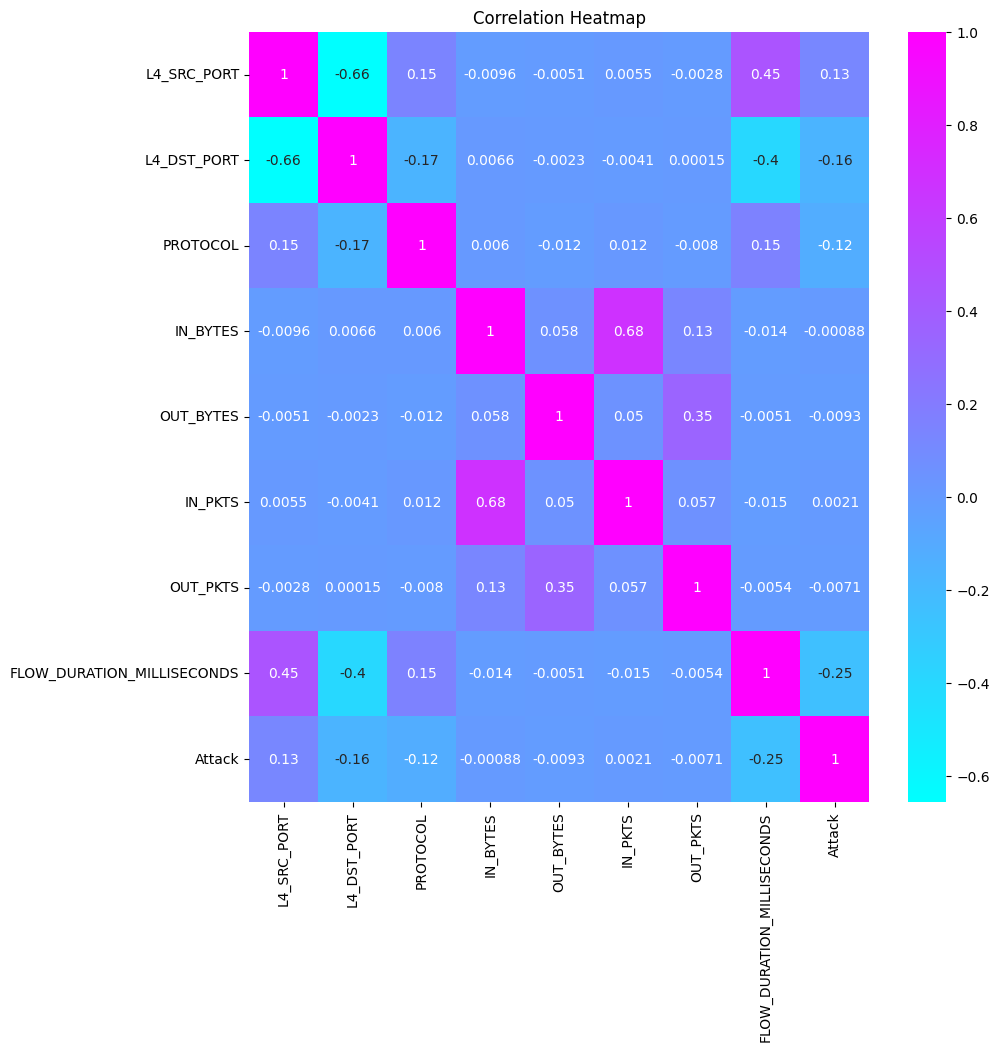

In [6]:
plt.figure(figsize=(10,10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='cool')
plt.title('Correlation Heatmap')
plt.show()

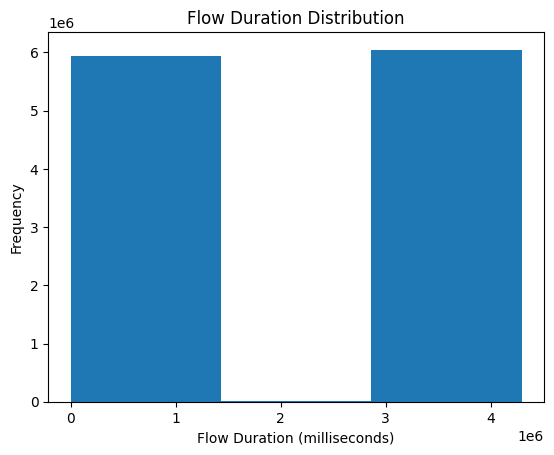

In [7]:
plt.hist(df['FLOW_DURATION_MILLISECONDS'], bins=3)
plt.xlabel('Flow Duration (milliseconds)')
plt.ylabel('Frequency')
plt.title('Flow Duration Distribution')
plt.show()

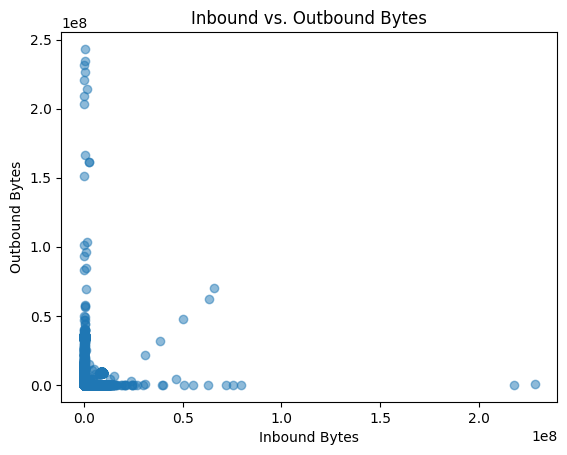

In [8]:
plt.scatter(df['IN_BYTES'], df['OUT_BYTES'], alpha=0.5)
plt.xlabel('Inbound Bytes')
plt.ylabel('Outbound Bytes')
plt.title('Inbound vs. Outbound Bytes')
plt.show()

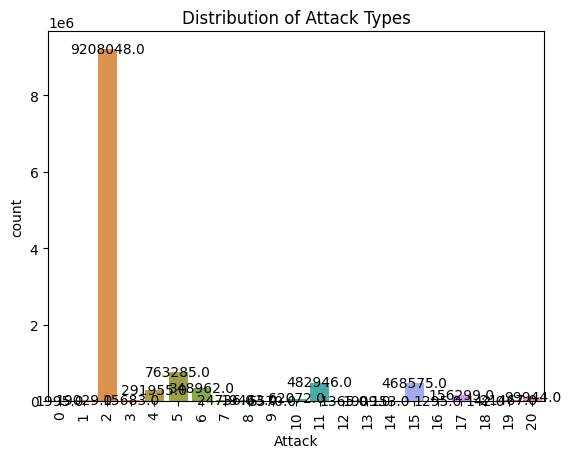

In [9]:
ax=sns.countplot(data=df, x='Attack')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()+2000),
                ha='center', va='center', fontsize=10, color='black',
                )

plt.xticks(rotation=90)

plt.title('Distribution of Attack Types')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11994893 entries, 0 to 11994892
Data columns (total 11 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   IPV4_SRC_ADDR               object
 1   L4_SRC_PORT                 int64 
 2   IPV4_DST_ADDR               object
 3   L4_DST_PORT                 int64 
 4   PROTOCOL                    int64 
 5   IN_BYTES                    int64 
 6   OUT_BYTES                   int64 
 7   IN_PKTS                     int64 
 8   OUT_PKTS                    int64 
 9   FLOW_DURATION_MILLISECONDS  int64 
 10  Attack                      int8  
dtypes: int64(8), int8(1), object(2)
memory usage: 926.6+ MB


In [11]:
df.isna().sum()

IPV4_SRC_ADDR                 0
L4_SRC_PORT                   0
IPV4_DST_ADDR                 0
L4_DST_PORT                   0
PROTOCOL                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
FLOW_DURATION_MILLISECONDS    0
Attack                        0
dtype: int64

In [12]:
df['Attack'].value_counts()

Attack
2     9208048
5      763285
11     482946
15     468575
6      348962
4      291955
17     156299
20      99944
10      62072
7       24736
19      21467
8       19463
1       19029
3       15683
9        5570
0        1995
13       1909
12       1365
16       1295
14        153
18        142
Name: count, dtype: int64

In [13]:
X = data.drop(['Attack'],axis=1)
y = data[['Attack']]

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X=X.reshape(X.shape[0],X.shape[1],1)

In [28]:
from tensorflow import keras
y = keras.utils.to_categorical(y, num_classes=21)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X.shape

(11994893, 8, 1)

In [31]:
y.shape

(11994893, 21)

In [32]:
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=1),
    Conv1D(32, kernel_size=3, activation='relu'), 
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(21, activation='sigmoid')
])

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
149937/149937 [==============================] - 661s 4ms/step - loss: 0.2757 - accuracy: 0.9092 - val_loss: 0.2284 - val_accuracy: 0.9219
Epoch 2/10
149937/149937 [==============================] - 629s 4ms/step - loss: 0.2239 - accuracy: 0.9224 - val_loss: 0.2152 - val_accuracy: 0.9261
Epoch 3/10
149937/149937 [==============================] - 626s 4ms/step - loss: 0.2156 - accuracy: 0.9252 - val_loss: 0.2073 - val_accuracy: 0.9264
Epoch 4/10
149937/149937 [==============================] - 631s 4ms/step - loss: 0.2132 - accuracy: 0.9268 - val_loss: 0.2121 - val_accuracy: 0.9273
Epoch 5/10
149937/149937 [==============================] - 688s 5ms/step - loss: 0.2136 - accuracy: 0.9276 - val_loss: 0.2117 - val_accuracy: 0.9266
Epoch 6/10
149937/149937 [==============================] - 657s 4ms/step - loss: 0.2132 - accuracy: 0.9280 - val_loss: 0.2138 - val_accuracy: 0.9287
Epoch 7/10
149937/149937 [==============================] - 642s 4ms/step - loss: 0.2087 - accuracy:

In [ ]:
model.save("cnn1.h5")

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 6, 16)             64        
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 6, 16)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 4, 32)             1568      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 4, 32)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [47]:
test_loss, test_accuracy = model.evaluate(X_test,y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}")


74969/74969 - 142s - loss: 0.2284 - accuracy: 0.9294 - 142s/epoch - 2ms/step
Test accuracy: 0.9294266700744629


74969/74969 - 141s - loss: 0.2284 - accuracy: 0.9294 - 141s/epoch - 2ms/step


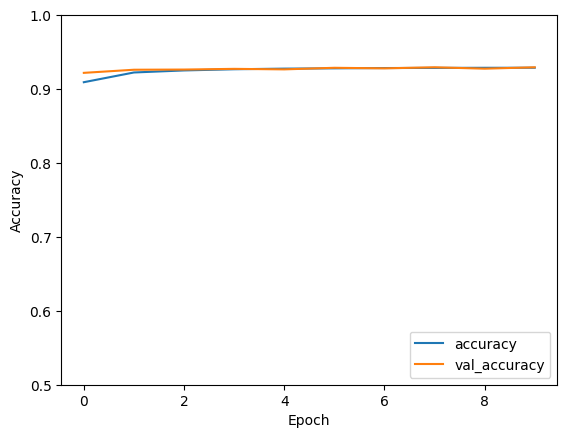

In [73]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_accuracy = model.evaluate(X_test,  y_test, verbose=2)

In [49]:
import numpy as np
predictions = model.predict(X_test)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

74969/74969 [==============================] - 116s 2ms/step


In [69]:
y_test1 = [np.argmax(x) for x in y_test]
y_test1

[2,
 2,
 2,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 15,
 2,
 2,
 2,
 2,
 6,
 2,
 8,
 2,
 15,
 15,
 6,
 5,
 2,
 2,
 6,
 2,
 2,
 2,
 5,
 2,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 20,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 15,
 2,
 11,
 2,
 2,
 11,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 11,
 2,
 2,
 2,
 17,
 2,
 2,
 11,
 2,
 2,
 2,
 15,
 19,
 2,
 2,
 2,
 5,
 2,
 17,
 2,
 2,
 5,
 15,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 15,
 2,
 2,
 5,
 2,
 2,
 2,
 11,
 2,
 2,
 2,
 11,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 6,
 15,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 11,
 2,
 2,
 2,
 17,
 2,
 2,
 2,
 2,
 6,
 4,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 11,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 7,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 15,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 15,
 2,
 2,
 5,
 2,
 

In [71]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_test1)
sns.heatmap(conf_matrix,cmap='cool')
plt.title('Confusion Matrix')


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

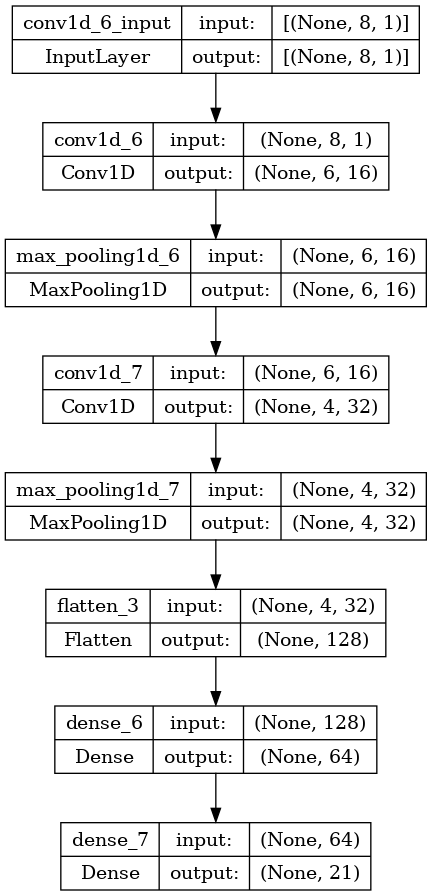

In [74]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
